# Machine Learning Analysis of `Simulation_5min.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error




## 1. Load & Inspect the Data

In [2]:

df = pd.read_csv('Simulation_5min.csv', header=None,
                 names=['time_s', 'global_step', 'measured', 'setpoint'])
print(df.head())
print(df.describe())


   time_s  global_step    measured  setpoint
0     300          386  101.262827     100.0
1     300          387   50.207357      50.0
2     300          388   50.409554      50.0
3     300          389   50.075980      50.0
4     300          390   47.895285      50.0
              time_s    global_step       measured       setpoint
count  507990.000000  507990.000000  507990.000000  507990.000000
mean    43200.000000    1110.467797      39.727136      61.129944
std     24854.802677    1100.192680      32.212188      20.035865
min       300.000000     386.000000       0.000000      20.000000
25%     21600.000000     647.000000       2.112059      50.000000
50%     43200.000000     933.000000      42.807048      50.000000
75%     64800.000000    1177.000000      51.621214      80.000000
max     86100.000000    6921.000000     120.165851     120.000000


## 2. Exploratory Data Analysis (EDA)

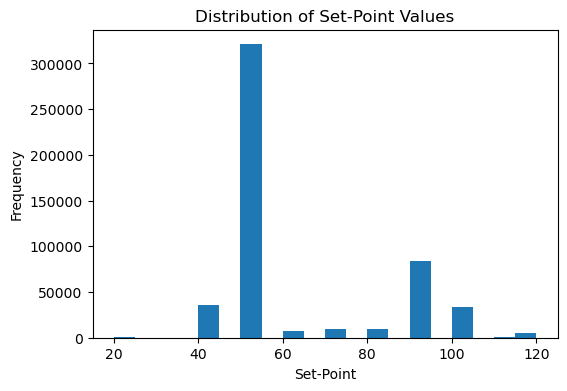

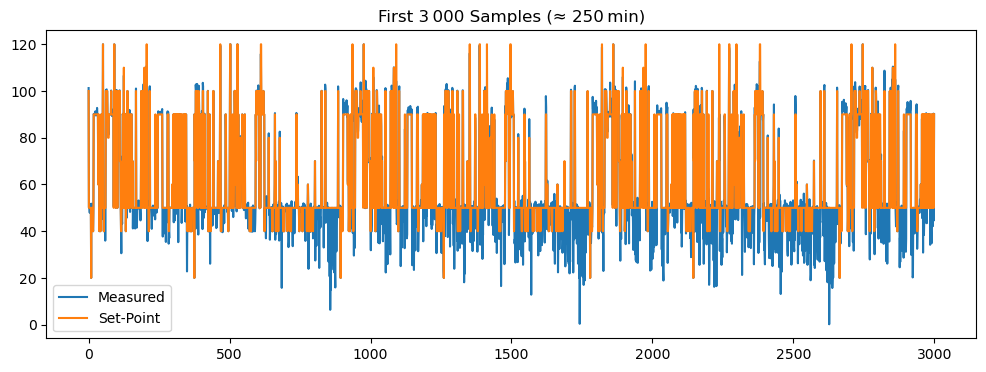

In [3]:
plt.figure(figsize=(6,4))
plt.hist(df['setpoint'], bins=20)
plt.title('Distribution of Set‑Point Values')
plt.xlabel('Set‑Point')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df['measured'][:3000], label='Measured')
plt.plot(df['setpoint'][:3000], label='Set‑Point')
plt.legend()
plt.title('First 3 000 Samples (≈ 250 min)')
plt.show()


## 3. Baseline Model
A simple but surprisingly strong baseline is to predict the measured signal by **simply returning the current set‑point**.

In [4]:
baseline_pred = df['setpoint'].values
baseline_mse  = mean_squared_error(df['measured'], baseline_pred)
baseline_mae  = mean_absolute_error(df['measured'], baseline_pred)
print(f"Baseline MSE: {baseline_mse:,.3f}")
print(f"Baseline MAE: {baseline_mae:,.3f}")


Baseline MSE: 1,264.975
Baseline MAE: 22.199


## 4. Prepare Sequence Data for the LSTM

In [5]:
SEQ_LEN = 20  # Use the previous 20 timesteps (~100 min) as context

features = df[['setpoint', 'measured']].values
targets  = df['measured'].values

X, y = [], []
for i in range(len(df) - SEQ_LEN):
    X.append(features[i:i+SEQ_LEN])
    y.append(targets[i+SEQ_LEN])

X, y = np.array(X), np.array(y)
print("Sequence tensor shape:", X.shape, y.shape)

# Chronological train‑test split (80‑20)
split_idx   = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Feature scaling (fit only on the training set to avoid leakage)
scaler = MinMaxScaler()
X_train_shape = X_train.shape
X_test_shape  = X_test.shape

# Flatten to 2‑D for scaler, then reshape back
X_train_flat = X_train.reshape(-1, X_train_shape[-1])
X_test_flat  = X_test.reshape(-1, X_test_shape[-1])

scaler.fit(X_train_flat)
X_train = scaler.transform(X_train_flat).reshape(X_train_shape)
X_test  = scaler.transform(X_test_flat).reshape(X_test_shape)


Sequence tensor shape: (507970, 20, 2) (507970,)


## 5. LSTM Time‑Series Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 2)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\obian\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265 (75.25 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stop = EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=256,
                    callbacks=[early_stop],
                    verbose=1)


Epoch 1/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - loss: 1185.6884 - val_loss: 862.8552
Epoch 2/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - loss: 712.0840 - val_loss: 847.3742
Epoch 3/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - loss: 702.7200 - val_loss: 843.3808
Epoch 4/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 696.8390 - val_loss: 832.6267
Epoch 5/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 684.8300 - val_loss: 810.4697
Epoch 6/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - loss: 662.7950 - val_loss: 781.6660
Epoch 7/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - loss: 621.9233 - val_loss: 722.1180
Epoch 8/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - loss: 561.4305 - val_loss: 662.9099
Epoch 9/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - loss: 498.4079 - val_loss: 594.3275
Epoch 10/10
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - loss: 446.1292 - val_loss: 536.0491


## 6. Evaluate & Visualise

LSTM Test MSE: 436.787
LSTM Test MAE: 16.863
Improvement over baseline (MSE): 65.47%


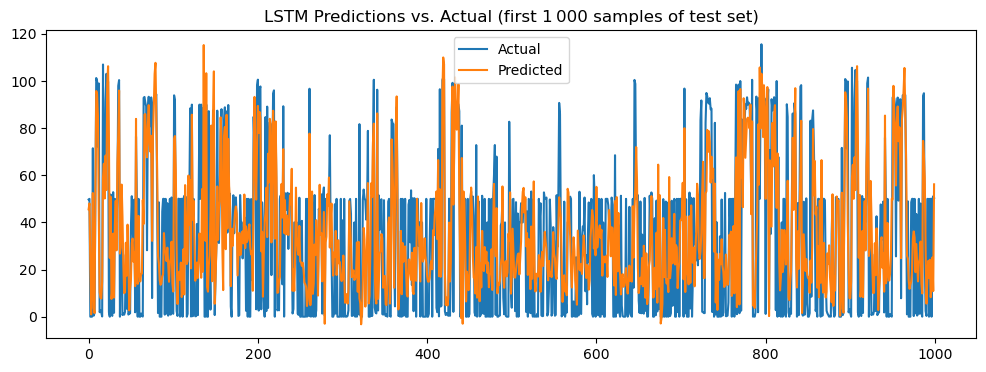

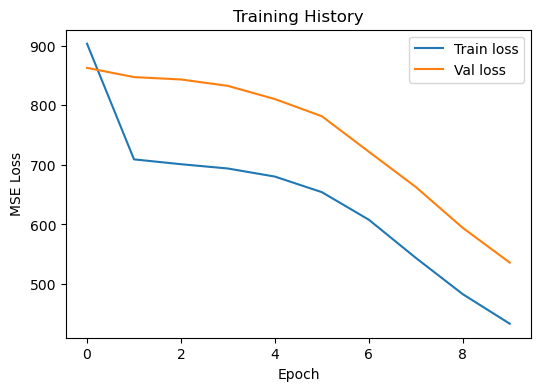

In [9]:
lstm_pred = model.predict(X_test, verbose=0).flatten()
lstm_mse   = mean_squared_error(y_test, lstm_pred)
lstm_mae   = mean_absolute_error(y_test, lstm_pred)

print(f"LSTM Test MSE: {lstm_mse:,.3f}")
print(f"LSTM Test MAE: {lstm_mae:,.3f}")
print(f"Improvement over baseline (MSE): {(baseline_mse - lstm_mse) / baseline_mse * 100:.2f}%")

# Plot predictions vs. actual
plt.figure(figsize=(12,4))
plt.plot(y_test[:1000], label='Actual')
plt.plot(lstm_pred[:1000], label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs. Actual (first 1 000 samples of test set)')
plt.show()

# Training history
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()
